## Loading 

### Loading the model

Loading in the model is straightforward, as the two-level dict structure can be directly converted into a `FlatMapping` that Haiku uses as parameters. Constructing the model itself is also easy, as it's just another `hk.Module` that you can use like any other Haiku model.

In [1]:
# Allows notebook to be run as though its at root of the repo
# instead of inside /notebooks
import sys
sys.path.insert(0, '..')

In [2]:
from esmjax import models, modelio, tokenize

import haiku as hk
import jax
import jax.numpy as jnp

We load in the model weights. As they're in the correct two level structure, we can pass them into `to_immutable_dict` which directly converts them into a `FlatMapping` ready for use. 

In [3]:
orig_params_dict = modelio.load_model("../weights/esm1b.h5")

# this converts each `numpy` array into a `jax.numpy` array
# automatically moving weights over to an accelerator if available
params_dict = jax.tree_map(lambda x: jnp.array(x), orig_params_dict)

params = hk.data_structures.to_immutable_dict(params_dict)

This notebook is being run on a TPU VM, and as we can see, the weights are indeed on the TPU

In [4]:
params['esm1b/embed']['embeddings'].device_buffer.device()

TpuDevice(id=0, process_index=0, coords=(0,0,0), core_on_chip=0)

Now, we construct the model function. The model is defined as a pure Haiku `hk.Module`, so we run it through a `hk.transform` o convert it to a "pure" function, just like any other Haiku model. We also run `without_apply_rng`, so we don't have to pass in a random key (this model isn't stochastic). We now have a Transformed function to use.

In [5]:
esm1b_f = hk.transform(lambda x: models.ESM1b()(x))
esm1b_f = hk.without_apply_rng(esm1b_f)

### Loading in data

There's a barebones tokenizer in `tokenizer.py` that accepts proteins the in the same `List[Tuple[str, str]]` format the original `esm` library does. The expectation is that the first `str` is the protein name (which is purely for user friendliness) and the second `str` is the actual amino acid sequence. Note we only process at the level of individual characters; `"LSQETFSDLWKL"` will be processed correctly whereas `"LSQET<mask>SDLWKL"` will not. This should suffice for processing FASTA files.

As an example, we use two proteins of very different lengths
* the [p53](https://en.wikipedia.org/wiki/P53) human homolog (392 residues)
* the d1n3ya_ used in Fig. 5 in [Rives et. al. (2021)](https://www.pnas.org/content/118/15/e2016239118) (189 residues)

In [6]:
data = [("P04637 (P53_HUMAN)", "MEEPQSDPSVEPPLSQETFSDLWKLLPENNVLSPLPSQAMDDLMLSPDDIEQWFTEDPGPDEAPRMPEAAPPVAPAPAAPTPAAPAPAPSWPLSSSVPSQKTYQGSYGFRLGFLHSGTAKSVTCTYSPALNKMFCQLAKTCPVQLWVDSTPPPGTRVRAMAIYKQSQHMTEVVRRCPHHRCSDSDGLAPPQHLIRVEGNLRVEYLDDRNTFRHSVVVPYEPPEVGSDCTTIHYNYMCNSSCMGGMNRRPILTIITLEDSSGNLLGRNSFEVRVCACPGRDRRTEEENLRKKGEPHHELPPGSTKRALPNNTSSSPQPKKKPLDGEYFTLQIRGRERFEMFRELNEALELKDAQAGKEPGGSRAHSSHLKSKKGQSTSRHKKLMFKTEGPDSD"),
        ("d1n3ya_", "QEQDIVFLIDGSGSISSRNFATMMNFVRAVISQFQRPSTQFSLMQFSNKFQTHFTFEEFRRSSNPLSLLASVHQLQGFTYTATAIQNVVHRLFHASYGARRDAAKILIVITDGKKEGDSLDYKDVIPMADAAGIIRYAIGVGLAFQNRNSWKELNDIASKPSQEHIFKVEDFDALKDIQNQLKEKIFAI")]

In [7]:
labels, sequences, tokens = tokenize.convert(data)

The `tokens` matrix is a batch x seq_len array of integers. The length is determined by the largest protein in the batch, and rounded up to the nearest power of two for efficient accelerator use. Each sequence has the following structure:

\<cls> amino acid sequence \<eos> \<pad> .... \<pad>

In [8]:
print(tokens, tokens.shape)

[[ 0 20  9 ...  1  1  1]
 [ 0 16  9 ...  1  1  1]] (2, 512)


## Computing embeddings

Use the `apply` method of the transformed function. The output is a dict with three keys
* `"embeddings"` which always has the embedding values from the final transformer layer (layer 33) with layer norm applied. 
* `"head_weights"` optionally holds the attention weights for each of the 33 x 20 heads if `head_weights=True` was passed into `ESM1b()` during construction.
* `"contacts"` holds the residue-residue contact prediction map, if `contacts=True` was passed into `ESM1b()` during construction. This also returns the raw `head_weights` as well.

Note that we need to use `float32` for stability here (`bfloat16` gives diverging results from original `torch` model on a TPU v2-8, will lift restriction once fixed)

In [9]:
with jax.default_matmul_precision('float32'):
    output = esm1b_f.apply(params, tokens)

Moreover, since this is a pure function, we can `jit` it per usual

In [10]:
esm1b_apply = jax.jit(esm1b_f.apply)

with jax.default_matmul_precision('float32'):
    output = esm1b_apply(params, tokens)

We now have access to a per residue embedding per protein:

In [11]:
output["embeddings"].shape # batch x seq_len x embed_dim

(2, 512, 1280)

Let's look at the per-residue embeddings for human p53. Note that all \<cls>, \<pad> and \<eos> tokens have their embeddings masked out.

In [12]:
output["embeddings"][0, :, :]

DeviceArray([[-0.        ,  0.        ,  0.        , ..., -0.        ,
               0.        , -0.        ],
             [ 0.1891916 , -0.02034626,  0.17725883, ..., -0.36895645,
              -0.20421334, -0.30043572],
             [ 0.39113018, -0.03493758, -0.12403283, ..., -0.33996534,
              -0.03953622, -0.02693968],
             ...,
             [-0.        ,  0.        , -0.        , ...,  0.        ,
              -0.        , -0.        ],
             [-0.        ,  0.        , -0.        , ...,  0.        ,
              -0.        , -0.        ],
             [-0.        ,  0.        , -0.        , ...,  0.        ,
              -0.        , -0.        ]], dtype=float32)

We can then compute a whole protein embedding by averaging over all the residues:

In [13]:
len_p53 = len(sequences[0])
p53_embed = output["embeddings"][0, 1:len_p53+1, :].mean(axis=1)

print(p53_embed[0:10], p53_embed.shape)

[0.00885688 0.00820896 0.00871334 0.00929441 0.00904433 0.00926742
 0.00915917 0.00975869 0.00911161 0.00887908] (392,)


## Predicting contact maps

Proteins are represented as sequences, but they're ultimately 3D structures; residues that are very far apart on the sequence may actually be quite close in 3D space. The model comes with the contact prediction head, which allows us to predict whether any two residues on a sequence are "in contact".

We first initialize the ESM1b with a contact prediction head. Note that this is quite memory intensive even at inference, as the model currently stores all 33 x 20 (660) attention head outputs to perform the contact prediction. This isn't necessary, as the weights are sparse, so only a few attention heads need to be stored, and this can be improved on.

In [14]:
esm1b_f = hk.transform(lambda x: models.ESM1b(contacts=True)(x))
esm1b_f = hk.without_apply_rng(esm1b_f)

In [15]:
# we only use the 2nd protein to avoid an OOM error here
data = [("d1n3ya_", "QEQDIVFLIDGSGSISSRNFATMMNFVRAVISQFQRPSTQFSLMQFSNKFQTHFTFEEFRRSSNPLSLLASVHQLQGFTYTATAIQNVVHRLFHASYGARRDAAKILIVITDGKKEGDSLDYKDVIPMADAAGIIRYAIGVGLAFQNRNSWKELNDIASKPSQEHIFKVEDFDALKDIQNQLKEKIFAI")]
labels, sequences, tokens = tokenize.convert(data)

In [16]:
with jax.default_matmul_precision('float32'):
    output = esm1b_f.apply(params, tokens)

We can then plot the residue-residue contact map. The protein here, d1n3ya_ is the same as used in Fig. 5 in the original Rives et. al. paper, and we see the contact map looks as expected.

Text(0.5, 1.0, 'd1n3ya_')

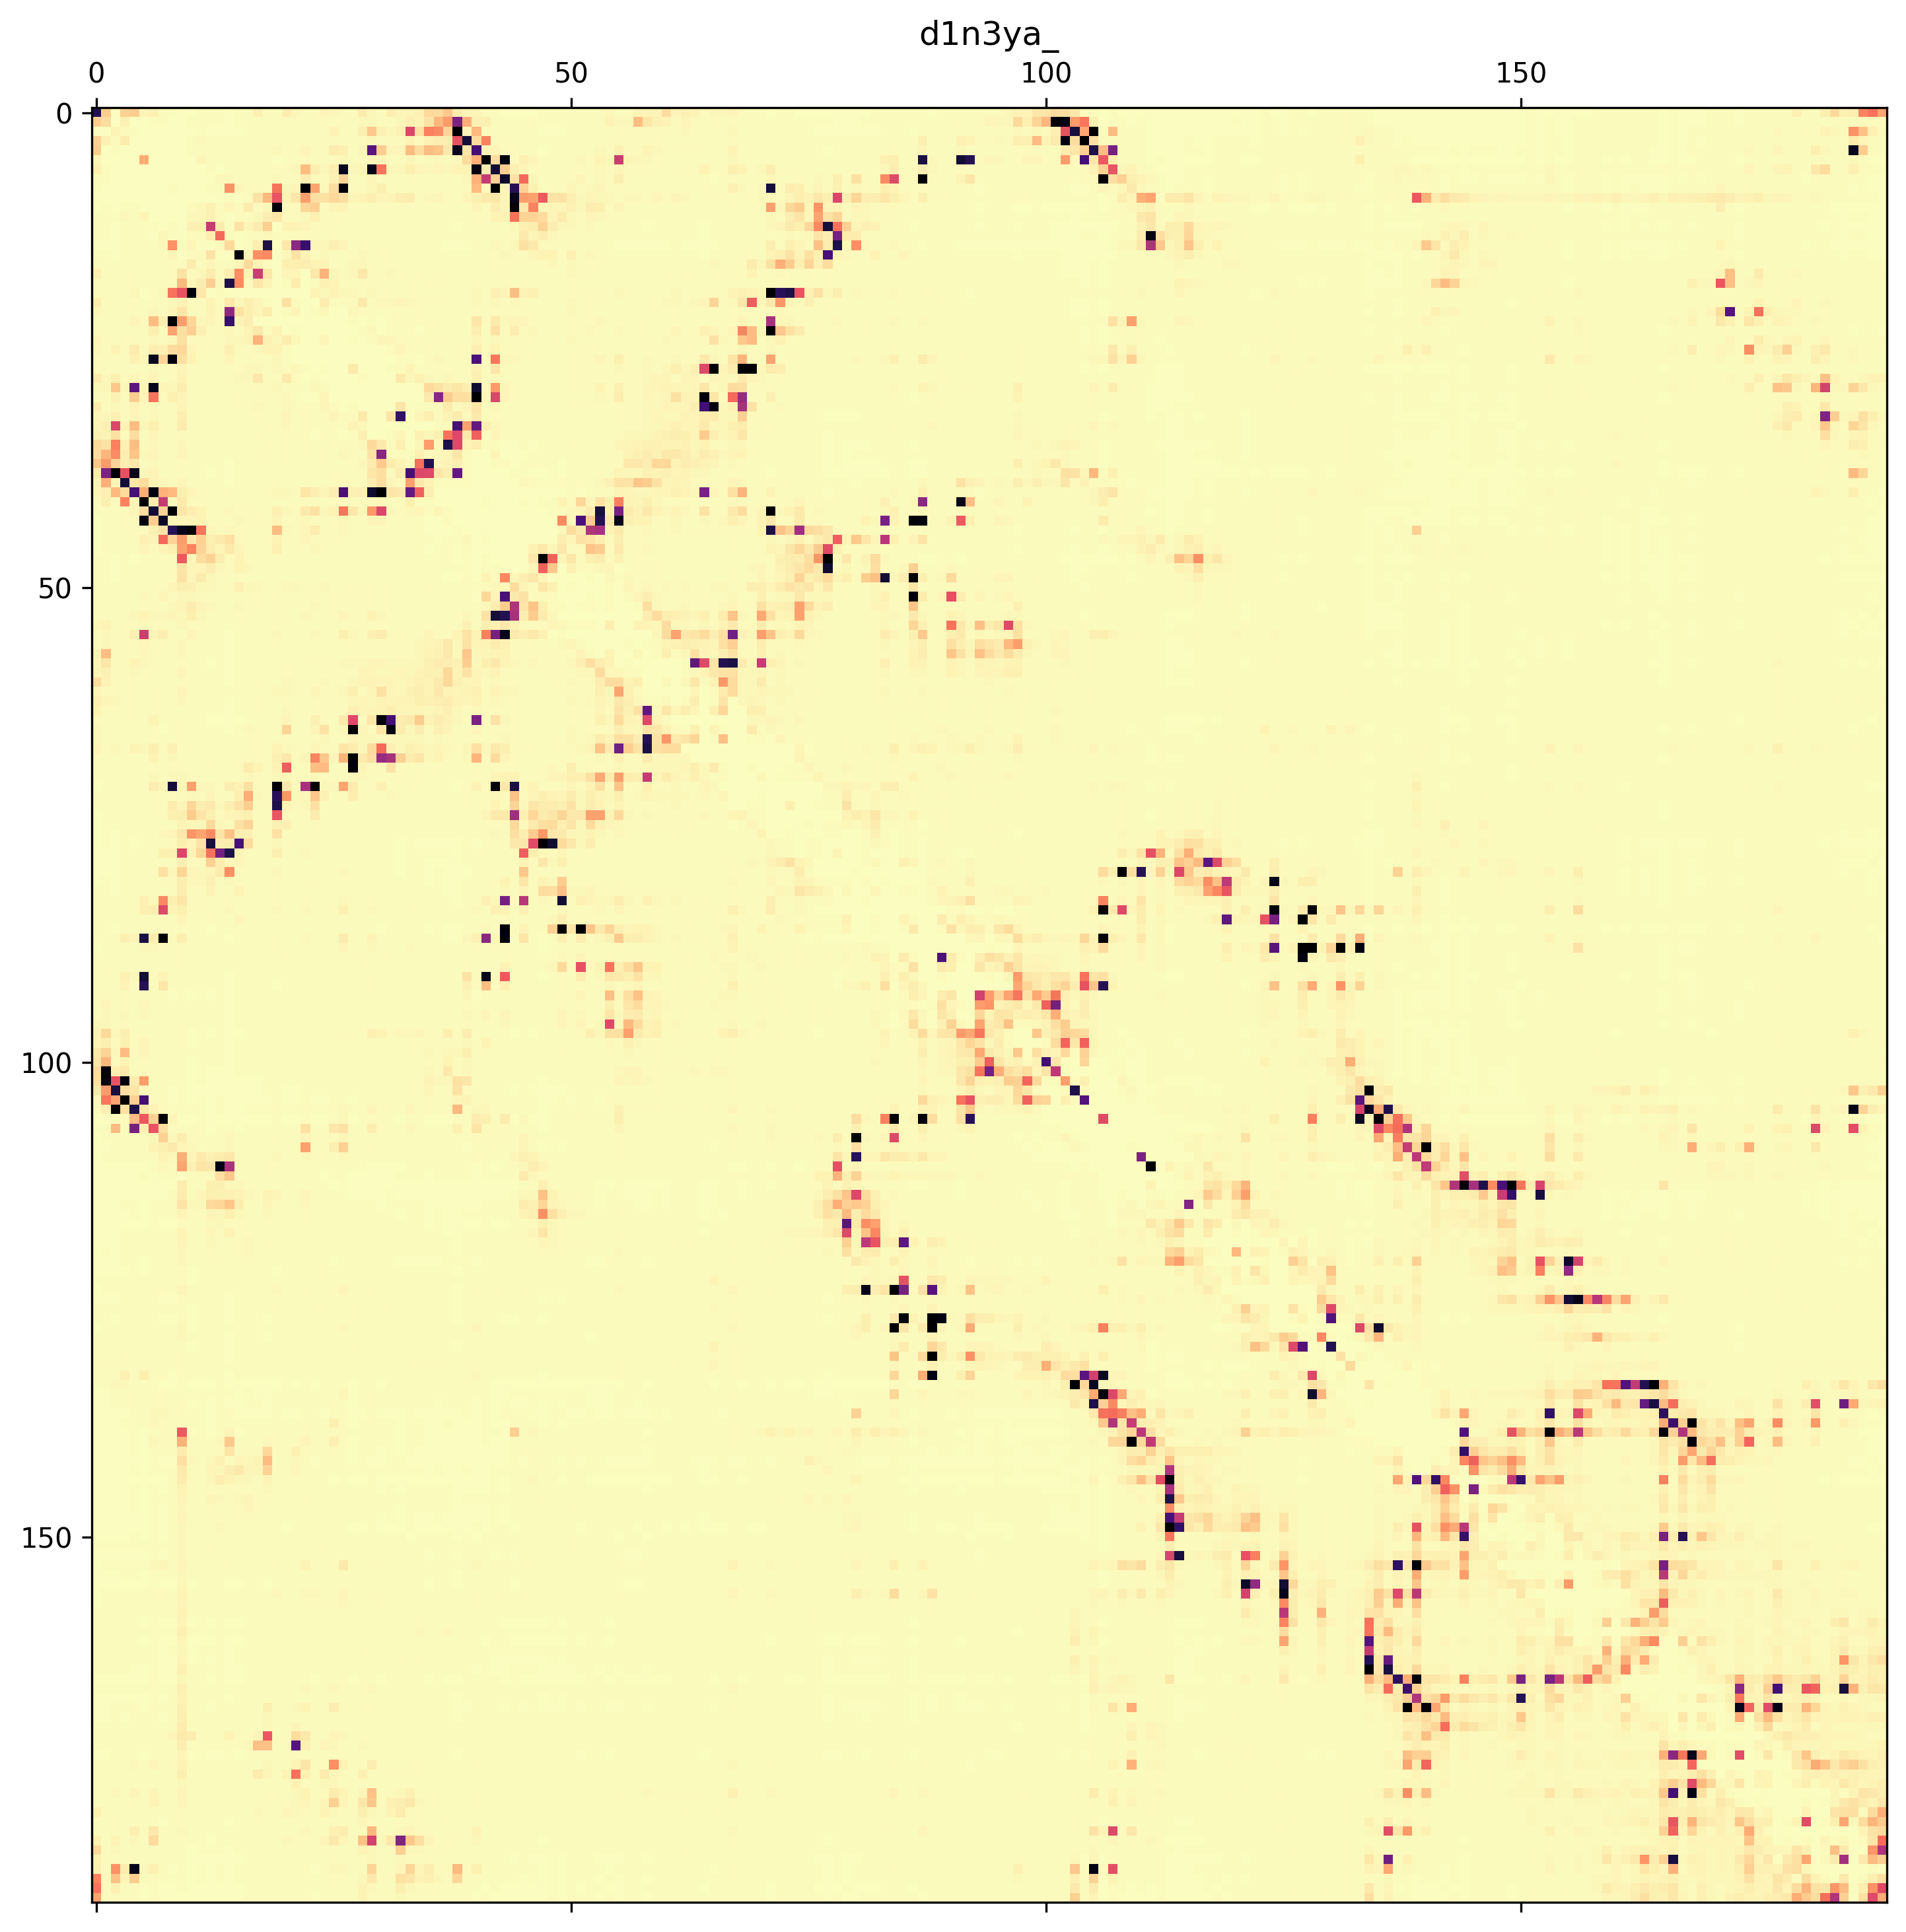

In [17]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(dpi=300, figsize=(12, 12))
prot_len = len(sequences[0])
ax.matshow(1-output["contacts"][0, 1:prot_len+1, 1:prot_len+1], cmap="magma")
ax.set_title(labels[0])

## Sanity testing

We quickly check our embedding and contact maps with that produced by the original PyTorch model [here](https://github.com/facebookresearch/esm) to make sure there isn't any divergence. We also use the original tokenizer to make sure ours isn't causing bugs.

In [18]:
import torch, esm

model, alphabet = esm.pretrained.esm1b_t33_650M_UR50S()
batch_converter = alphabet.get_batch_converter()

In [19]:
batch_labels, batch_strs, batch_tokens = batch_converter(data)

In [20]:
with torch.no_grad():
    results = model(batch_tokens, repr_layers=[33], return_contacts=True)

As we see, they're pretty close, both in the embeddings and contact maps predicted

In [21]:
pyt_embed = results["representations"][33][0, 1:1+prot_len, :].numpy()
jax_embed = output["embeddings"][0, 1:1+prot_len, :]
jnp.abs(jax_embed - pyt_embed).max()

DeviceArray(9.536743e-06, dtype=float32)

In [22]:
pyt_contact = results["contacts"][0, :prot_len, :prot_len].numpy()
jax_contact = output["contacts"][0, 1:1+prot_len, 1:1+prot_len]
jnp.abs(pyt_contact - jax_contact).max()

DeviceArray(1.6242266e-05, dtype=float32)